## Libs

In [1]:
# install.packages("BiocManager")
# BiocManager::install("impute")
# BiocManager::install("limma")
# BiocManager::install("RColorBrewer", force = TRUE)
# BiocManager::install("vegan")
# BiocManager::install("ggplot2")
# BiocManager::install("Biobase")
# BiocManager::install("ape")
# BiocManager::install("dendextend")
# install.packages("psych")
# BiocManager::install("gprofiler2")
# BiocManager::install("dplyr")
# BiocManager::install("pvclust")
# BiocManager::install("NMF")
# BiocManager::install("enrichplot")
# install.packages("FactoMineR")
# install.packages("gprofiler2")
# install.packages("tidyr")


In [2]:
library(readxl)
library(limma)
library(ape)
library(dendextend)
library(RColorBrewer)
library(pvclust)
library(gplots)
library(NMF)
library(vegan)
library(Biobase)
library(DT)
library(ggplot2)
library(impute)
library(ggrepel)
library(enrichplot)
library(FactoMineR)
library(psych)
library(gprofiler2)
library(tidyr)



---------------------
Welcome to dendextend version 1.17.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: 'dendextend'


The following objects are masked from 'package:ape':

    ladderize, rotate


The following object is masked from 'package:stats':

    cutree


Registered S3 method overwritten by 'pvclust':
  method       from      
  text.pvclust dendextend


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess


Loading required package: registry

Lo

## EDA

In [3]:
df <- read.csv("peaks_data.csv")


In [4]:
head(df, 3)


,Description...,Accession,Gene_id,BT_1,BT_2,BT_3,BT_4,BT_5,BT_6,BT_7,...,CJK_10,CJK_11,CJK_12,CJK_13,CJK_14,CJK_16,CJK_17,CJK_18,CJK_19,CJK_20
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Neuroblast differentiation-associated protein AHNAK OS=Homo sapiens OX=9606 GN=AHNAK PE=1 SV=2,Q09666|AHNK_HUMAN,AHNAK,3208900000,2374900000,2.8808e+09,1909900000,3236700000,3255400000,3441100000,...,3463400000,7.2585e+09,1182700000,2700500000,2351600000,1754100000,1479000000,1692100000,595420000,1666300000
2,Plectin OS=Homo sapiens OX=9606 GN=PLEC PE=1 SV=3,Q15149|PLEC_HUMAN,PLEC,1943300000,2154300000,1.8461e+09,2267400000,1739200000,3055300000,793750000,...,2864700000,3.3625e+09,1242900000,1354800000,1511200000,984310000,1251900000,1832600000,292760000,1066500000
3,Myosin-9 OS=Homo sapiens OX=9606 GN=MYH9 PE=1 SV=4,P35579|MYH9_HUMAN,MYH9,4878900000,3330900000,1.0736e+10,6690100000,5485700000,4331500000,6710200000,...,7076500000,1.1502e+10,909280000,4644600000,5552000000,5250200000,4220100000,5980200000,1907800000,4852900000


In [5]:
dim(df)


[1] 3634   36

### Dropping samples with more than a half nans

In [6]:
total_cols <- ncol(df[, !names(df) %in% c("Accession", "Gene_id")])

# Calculate threshold for more than half NaNs
half_threshold <- total_cols / 2

# Identify rows with more than half NaNs
nan_row_counts <- rowSums(is.na(df[, !names(df) %in% c("Accession", "Gene_id")]))

# Get names of rows where NaN count exceeds half the total number of columns
nan_rows <- rownames(df)[nan_row_counts > half_threshold]

df <- df[!rownames(df) %in% nan_rows, ]
dim(df)


[1] 2382   36

In [7]:
dim(df)


[1] 2382   36

In [8]:
# dropping nans in gene_id, they are duplicated
df <- df[which(!duplicated(df$Gene_id)), ]


In [9]:
dim(df)


[1] 2358   36

## Imputation of missed data using KNN

In [10]:
df_m <- as.matrix(df[, !names(df) %in% c("Accession", "Gene_id")])
df_m <- t(df_m)
df_m <- df_m[-1, ]
knn_df <- impute.knn(df_m, k = 5)
df_m <- knn_df$data
df_m <- as.data.frame(df_m)
df_m <- t(as.matrix(df_m))
head(df_m, 3)


,BT_1,BT_2,BT_3,BT_4,BT_5,BT_6,BT_7,BT_8,BT_9,BT_10,...,CJK_10,CJK_11,CJK_12,CJK_13,CJK_14,CJK_16,CJK_17,CJK_18,CJK_19,CJK_20
1,3208900000,2374900000,2.8808e+09,1909900000,3236700000,3255400000,3441100000,2948000000,2548700000,1770600000,...,3463400000,7.2585e+09,1182700000,2700500000,2351600000,1754100000,1479000000,1692100000,595420000,1666300000
2,1943300000,2154300000,1.8461e+09,2267400000,1739200000,3055300000,793750000,1187500000,1402000000,1922900000,...,2864700000,3.3625e+09,1242900000,1354800000,1511200000,984310000,1251900000,1832600000,292760000,1066500000
3,4878900000,3330900000,1.0736e+10,6690100000,5485700000,4331500000,6710200000,5387200000,5847800000,5327800000,...,7076500000,1.1502e+10,909280000,4644600000,5552000000,5250200000,4220100000,5980200000,1907800000,4852900000


## Normalizing data

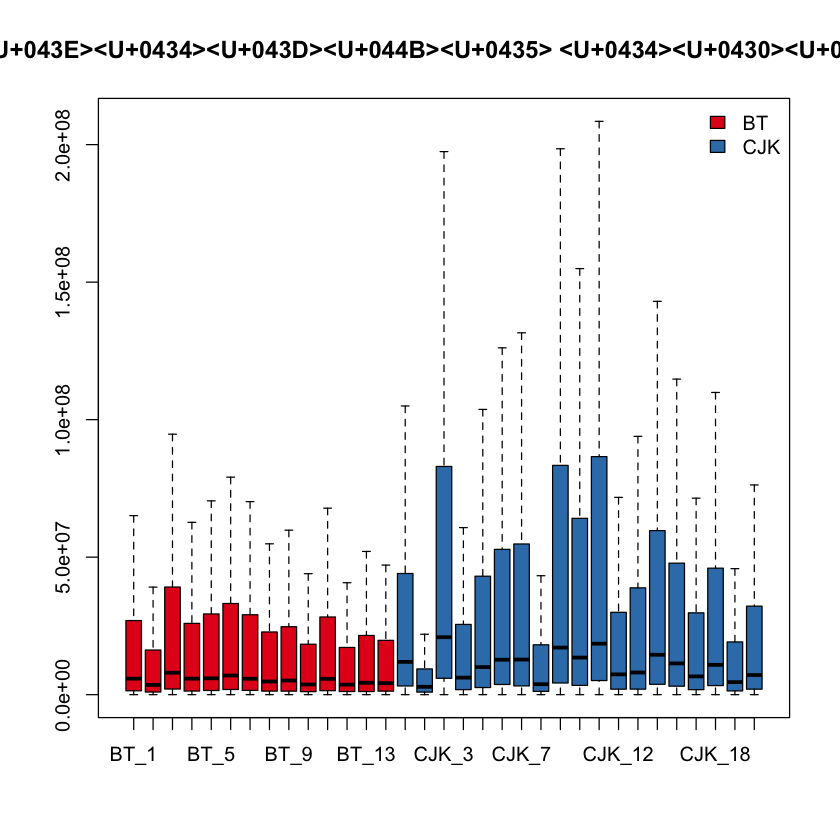

In [11]:
experiment <- as.factor(sapply(strsplit(colnames(df_m), "_"), `[`, 1))
pal <- brewer.pal(n = 9, name = "Set1")
cols <- pal[experiment]

boxplot(df_m, outline = FALSE, main = "Исходные данные", col = cols)
legend("topright", levels(experiment), fill = pal, bty = "n", xpd = T)


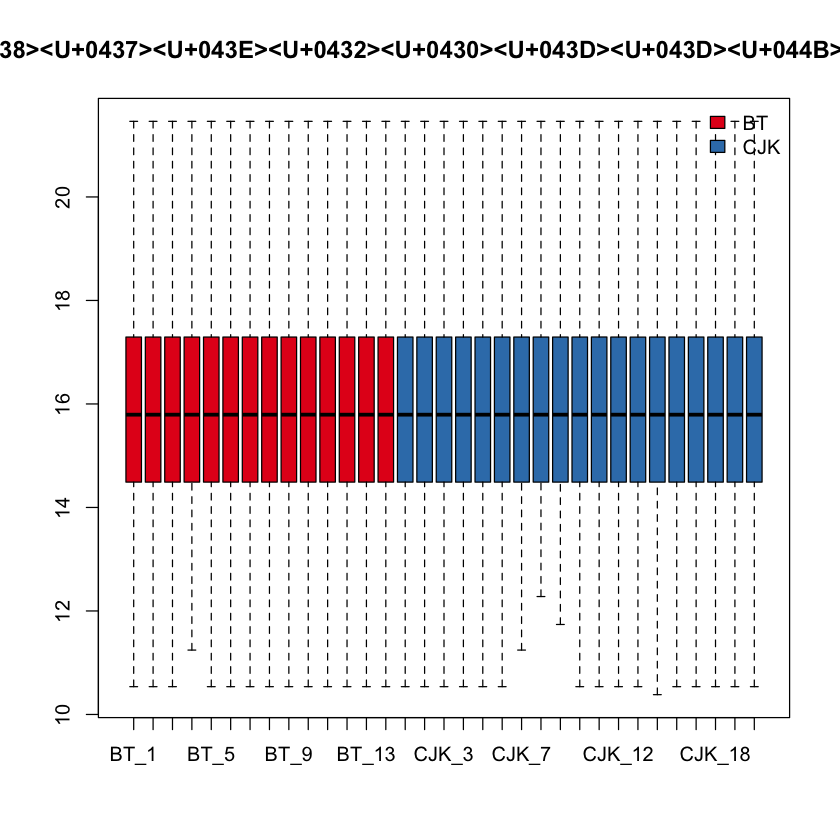

In [12]:
df_log <- log(df_m + 1)
df_norm <- normalizeQuantiles(as.matrix(df_log))

boxplot(df_norm, outline = FALSE, main = "Нормализованные данные", col = cols)
legend("topright", levels(experiment), fill = pal, bty = "n", xpd = T)


## Evaluating batch effect using PCA

Samples clustered based on biological conditions rather than batches, so biological variability is the dominant factor, not batch effect.

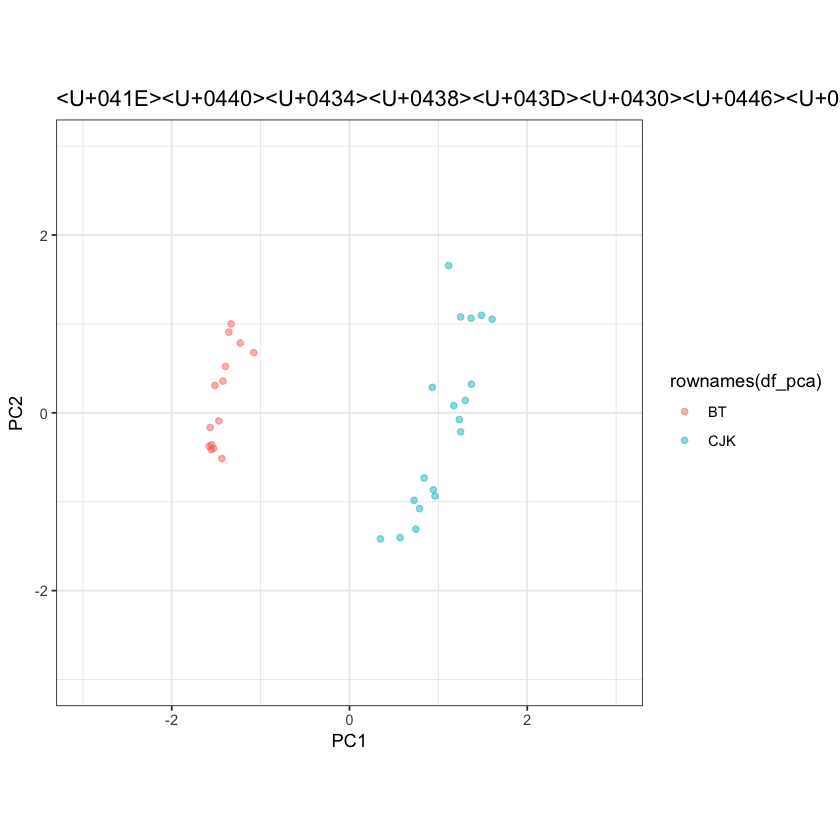

In [13]:
df_pca <- t(df_norm)
rda_pca <- rda(df_pca, scale = TRUE)

rownames(df_pca) <- experiment

df_scores <- data.frame(
    df_pca,
    scores(rda_pca, display = "sites", choices = c(1, 2, 3), scaling = "sites")
)

p_scores <- ggplot(df_scores, aes(x = PC1, y = PC2)) +
    geom_point(aes(color = rownames(df_pca)), alpha = 0.5) +
    coord_equal(xlim = c(-3, 3), ylim = c(-3, 3)) +
    ggtitle(label = "Ординация в осях главных компонент") +
    theme_bw()
p_scores


In [14]:
maplot <- function(X1, X2, pch = 21, main = "MA-plot", xlab = "Average log-expression", ylab = "Expression log-ratio", lpars = list(col = "blue", lwd = 2), ...) {
  X <- (rowMeans(X2) + rowMeans(X1)) / 2
  Y <- rowMeans(X2) - rowMeans(X1)
  scatter.smooth(x = X, y = Y, main = main, pch = pch, xlab = xlab, ylab = ylab, lpars = lpars, ...)
  abline(h = c(-1, 0, 1), lty = c(2, 1, 2))
}


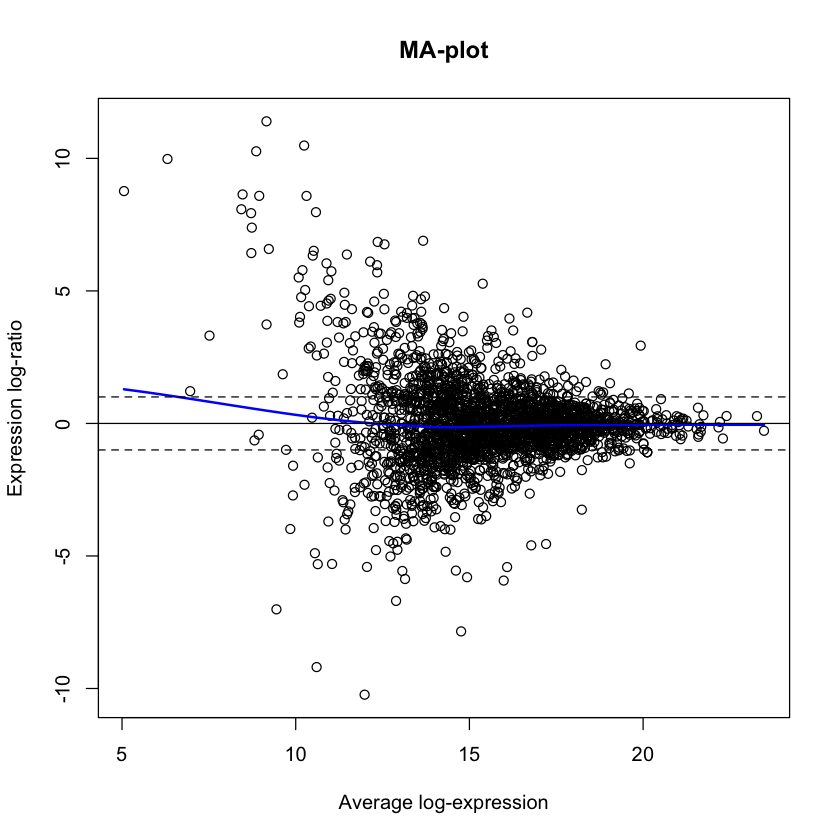

In [15]:
maplot(df_norm[, 1:14], df_norm[, 14:32])


## Differential expression

In [16]:
expr_data <- as.matrix(df_norm)

pheno_data <- data.frame(experiment)
rownames(pheno_data) <- colnames(df_m)
pheno_metadata <- data.frame(
    labelDescription = c("Experimental condition"),
    row.names = c("Condition")
)
pheno_data <- new("AnnotatedDataFrame",
    data = pheno_data,
    varMetadata = pheno_metadata
)

feature_data <- data.frame(Prot = df$Gene_id)
rownames(feature_data) <- rownames(expr_data)
feature_metadata <- data.frame(
    labelDescription = c("Protain name"),
    row.names = c("Protain")
)
f_data <- new("AnnotatedDataFrame",
    data = feature_data,
    varMetadata = feature_metadata
)

exp_set <-
    ExpressionSet(
        assayData = expr_data,
        phenoData = pheno_data,
        featureData = f_data
    )


In [17]:
X <- model.matrix(~experiment, pData(exp_set))
fit <- lmFit(exp_set, design = X, method = "robust", maxit = 1000)
efit <- eBayes(fit)


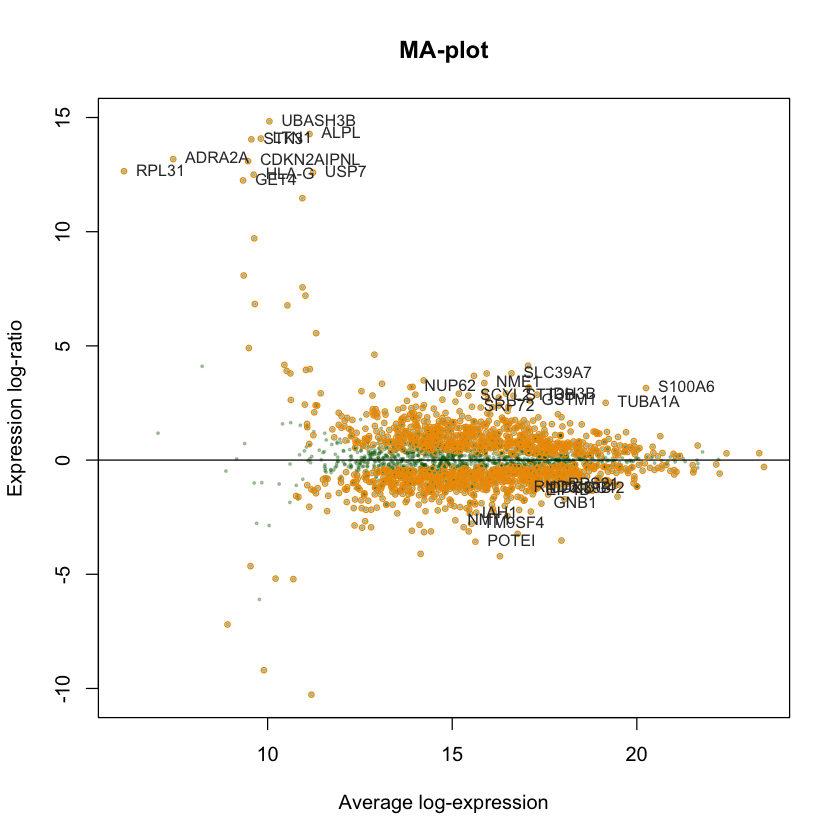

In [18]:
MA_limma <- function(efit, coef, n = 10, signif = TRUE, fdr = 0.05, lfc = 0, text = TRUE, cex.text = 0.8, col.text = "grey20", main = "MA-plot", xlab = "Average log-expression", ylab = "Expression log-ratio", pch = 19, pch.signif = 21, col = "darkgreen", alpha = 0.3, cex = 0.3, ...) {
  R <- efit$coefficients[, coef]
  I <- efit$Amean
  col_btransp <- adjustcolor(col, alpha.f = alpha)
  plot(I, R, cex = cex, main = main, pch = pch, xlab = xlab, ylab = ylab, col = col_btransp, ...)
  abline(h = 0)
  if (signif) {
    sign <- p.adjust(efit$p.value[, coef], method = "BH") <= fdr
    large <- abs(efit$coefficients[, coef]) >= lfc
    points(I[sign & large], R[sign & large], cex = cex * 2, col = "orange2", pch = pch.signif)
  }
  if (text) {
    ord <- order(efit$lods[, coef], decreasing = TRUE)
    top_n <- ord[1:n]
    text(I[top_n], R[top_n], labels = efit$genes[top_n, ], pos = 4, cex = cex.text, col = col.text)
  }
}

MA_limma(efit, coef = 2, n = 30)


In [19]:
my_list <- topTable(efit, coef = 2, n = 100)
dif_exp_set <- exp_set[fData(exp_set)$Prot %in% my_list$Prot, ]


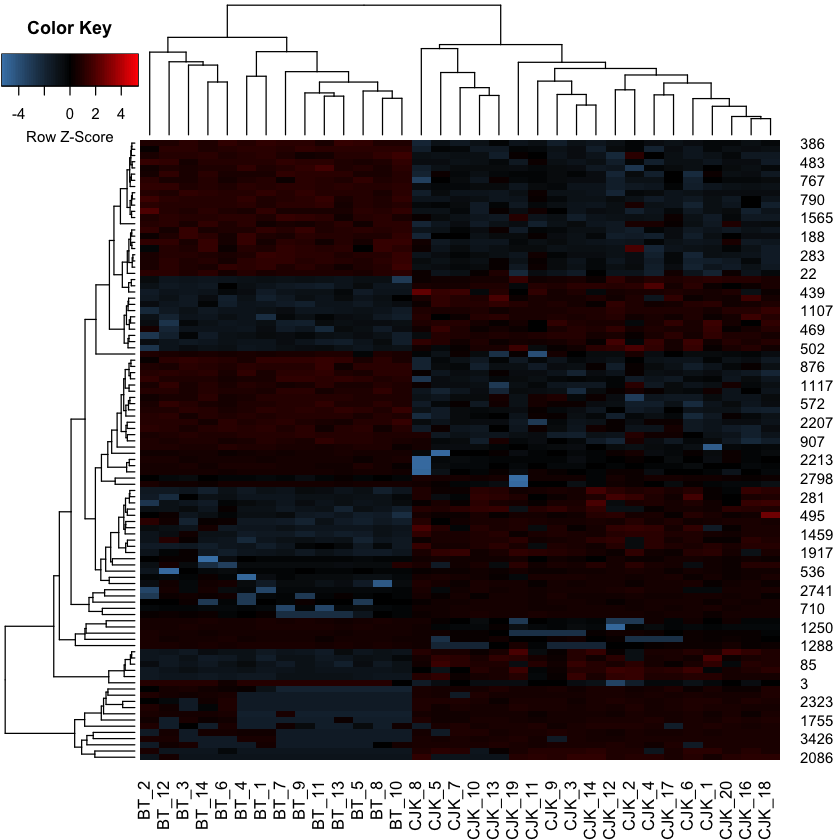

In [20]:
dat <- as.matrix(exprs(dif_exp_set))
pal_blue_red <- colorpanel(75, low = "steelblue", mid = "black", high = "red")
heatmap.2(dat, col = pal_blue_red, scale = "row", key = TRUE, symkey = FALSE, density.info = "none", trace = "none", cexRow = 0.9, cexCol = 1, margins = c(4, 3), keysize = 0.8, key.par = list(mar = c(3, 0.1, 3, 0.1)))


In [21]:
topTable(efit, coef = 2)
numGenes <- nrow(exprs(exp_set))
full_list <- topTable(efit, number = numGenes)
full_list <- full_list[full_list$adj.P.Val <= 0.05, ]
write.csv(full_list, "DE_full.csv")


,Prot,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1648,LTN1,14.077737,9.816411,112.30989,2.540956e-44,5.991574e-41,84.04296
3426,STK3,14.044865,9.558795,91.52556,2.175325e-41,2.564708e-38,80.23407
2086,RPL31,12.649212,6.109901,89.50561,4.540227e-41,3.568619e-38,78.98699
2323,UBASH3B,14.832774,10.047799,72.76984,4.149447e-38,2.446099e-35,74.51061
1557,ADRA2A,13.181117,7.442425,39.75279,1.615171e-29,7.617148e-27,57.17183
2923,CDKN2AIPNL,13.088715,9.470104,32.39256,1.200618e-26,4.718429e-24,50.75230
710,NME1,3.374454,15.868952,26.84967,4.793414e-24,1.614696e-21,44.89735
1947,TM9SF4,-2.791038,15.519306,-26.68569,5.820058e-24,1.715462e-21,44.69626
1107,GSTM1,2.609264,17.096429,24.75184,6.253871e-23,1.638514e-20,42.34138


Removing intercept from test coefficients



In [22]:
nrow(full_list)


[1] 1402

In [23]:
volcano_list <- full_list

volcano1 <- ggplot(data = volcano_list, aes(x = experiment, y = -log10(adj.P.Val))) +
  geom_point()

volcano2 <- volcano1 + geom_vline(xintercept = c(-0.6, 0.6), col = "red") +
  geom_hline(yintercept = -log10(0.05), col = "red")

volcano_list$diffexpressed <- "NO"


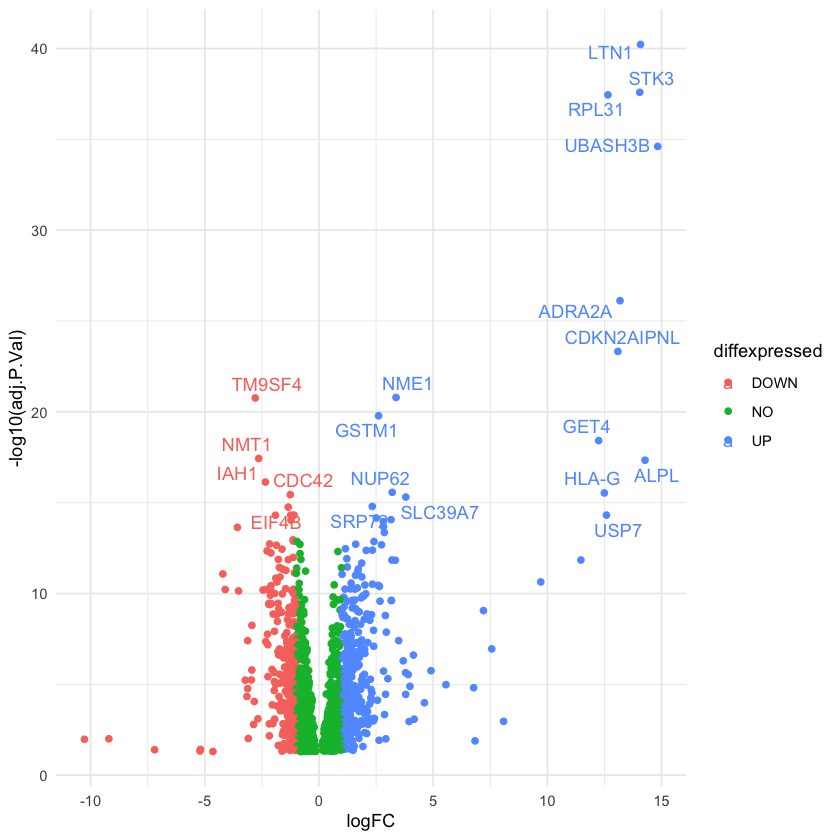

In [24]:
volcano_list$diffexpressed[volcano_list$logFC > 1 & volcano_list$adj.P.Val < 0.05] <- "UP"
volcano_list$diffexpressed[volcano_list$logFC < -1 & volcano_list$adj.P.Val < 0.05] <- "DOWN"
volcanodif1 <- ggplot(data = volcano_list, aes(x = logFC, y = -log10(adj.P.Val), col = diffexpressed)) +
    geom_point() +
    theme_minimal() +
    geom_text_repel(data = head(volcano_list, 20), aes(label = head(volcano_list, 20)$Prot))
volcanodif1


In [25]:
length(volcano_list$diffexpressed[volcano_list$logFC > 1 & volcano_list$adj.P.Val < 0.05])


[1] 324

In [26]:
length(volcano_list$diffexpressed[volcano_list$logFC < -1 & volcano_list$adj.P.Val < 0.05])


[1] 266

Warning message in brewer.pal(length(levels(group)), name = palette):
"n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
"


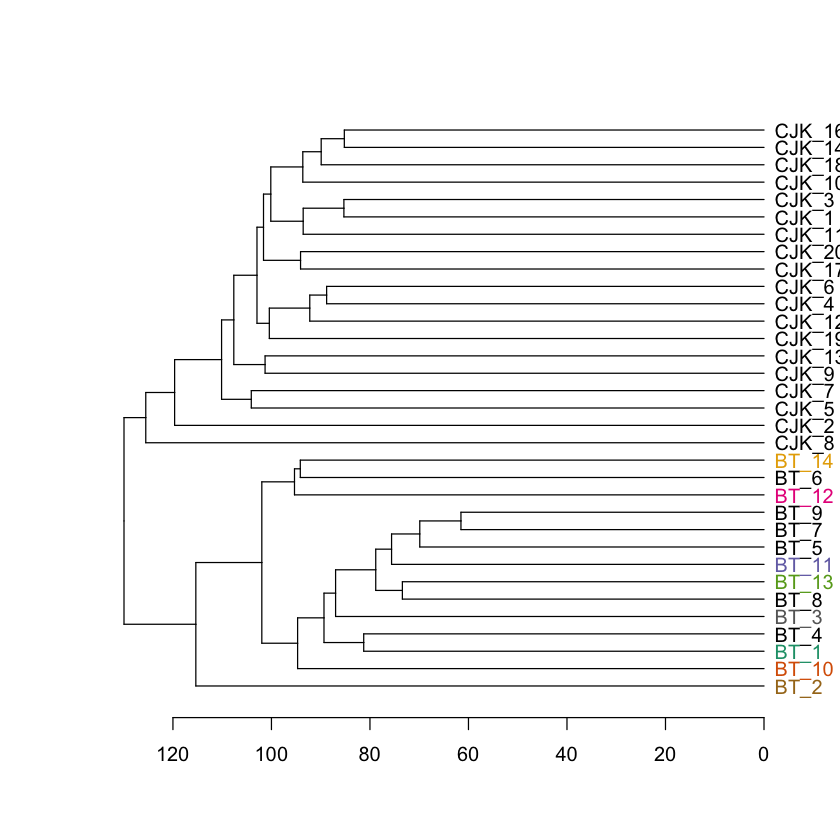

In [27]:
diff_prot <- rownames(full_list)
diff_expressed <- as.data.frame(df_norm)[diff_prot, ]
t_diff_expressed <- t(diff_expressed)
# rownames(t_diff_expressed) <-  as.factor(gsub("_[^_]*", replacement = "", rownames(t_diff_expressed)))
# rownames(t_diff_expressed) <- make.unique(as.character(pheno$df_experiment))

d <- dist(x = t_diff_expressed, method = "canberra")

mouse_hc_avg <- hclust(d, method = "average")
mouse_ph_avg <- as.phylo(mouse_hc_avg)
mouse_den_avg <- as.dendrogram(mouse_hc_avg)

get_colours <- function(dend, n_chars, palette = "Dark2") { # nchars = первые нескольок симовлов которые будут использоваться для разделения фактора на группы
    labs <- get_leaves_attr(dend, "label")
    group <- substr(labs, start = 0, stop = n_chars)
    group <- factor(group)
    cols <- brewer.pal(length(levels(group)), name = palette)[group]
    return(cols)
}

cols <- get_colours(dend = mouse_den_avg, n_chars = 6)
den_avg_c <- color_labels(dend = mouse_den_avg, col = cols)
plot(den_avg_c, horiz = TRUE)


## Enrichment

LFC > 0 and < 0

In [28]:
sig <- subset(full_list, adj.P.Val < 0.05)
up <- subset(sig, logFC > 0)
down <- subset(sig, logFC < 0)

up_names <- gconvert(up$Prot)
down_names <- gconvert(down$Prot)


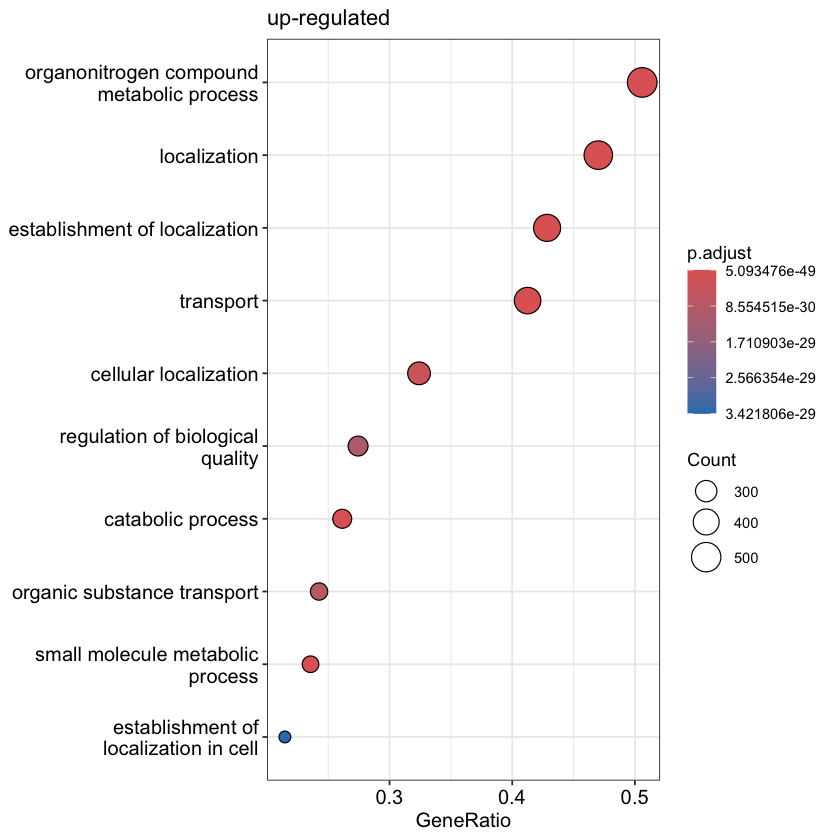

In [29]:
## Up-regulated proteins

# enrichment analysis using proteins names
multi_gp_up_reg <- gost(list("up-regulated" = up_names), multi_query = FALSE, evcodes = TRUE)
# modify the g:Profiler data frame
gp_mod_up <- multi_gp_up_reg$result[, c("query", "source", "term_id", "term_name", "p_value", "query_size", "intersection_size", "term_size", "effective_domain_size", "intersection")]
gp_mod_up <- gp_mod_up[order(gp_mod_up$p_value), ]
gp_mod_up_BP <- gp_mod_up[gp_mod_up$source == "GO:BP", ]
gp_mod_up_BP$GeneRatio <- paste0(gp_mod_up_BP$intersection_size, "/", gp_mod_up_BP$query_size)
gp_mod_up_BP$BgRatio <- paste0(gp_mod_up_BP$term_size, "/", gp_mod_up_BP$effective_domain_size)
names(gp_mod_up_BP) <- c("Cluster", "Category", "ID", "Description", "p.adjust", "query_size", "Count", "term_size", "effective_domain_size", "geneID", "GeneRatio", "BgRatio")
gp_mod_up_BP$geneID <- gsub(",", "/", gp_mod_up_BP$geneID)
row.names(gp_mod_up_BP) <- gp_mod_up_BP$ID
gp_mod_enrich_up_BP <- new("enrichResult", result = gp_mod_up_BP)

enrichplot::dotplot(gp_mod_enrich_up_BP, showCategory = 10) + ggplot2::labs(title = "up-regulated") + ggplot2::scale_color_gradient(low = "lightseagreen", high = "darkorange1")


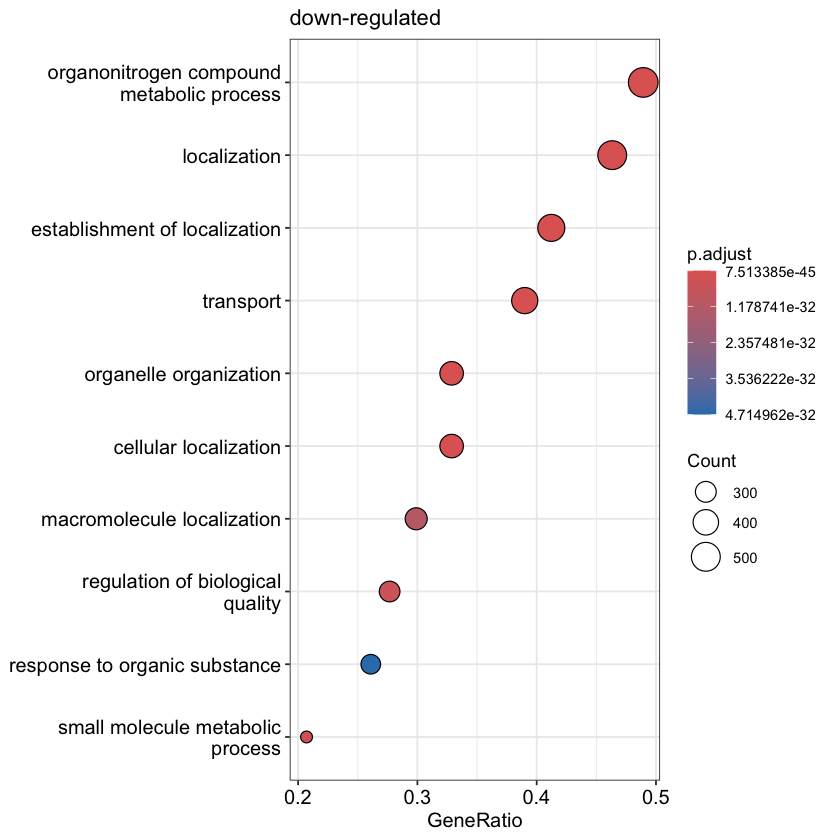

In [30]:
## Down-regulated proteins

# enrichment analysis using gene names
multi_gp_down_reg <- gost(list("down-regulated" = down_names), multi_query = FALSE, evcodes = TRUE)
# modify the g:Profiler data frame
gp_mod_down <- multi_gp_down_reg$result[, c("query", "source", "term_id", "term_name", "p_value", "query_size", "intersection_size", "term_size", "effective_domain_size", "intersection")]
gp_mod_down <- gp_mod_down[order(gp_mod_down$p_value), ]
# BP
gp_mod_down_BP <- gp_mod_down[gp_mod_down$source == "GO:BP", ]
gp_mod_down_BP$GeneRatio <- paste0(gp_mod_down_BP$intersection_size, "/", gp_mod_down_BP$query_size)
gp_mod_down_BP$BgRatio <- paste0(gp_mod_down_BP$term_size, "/", gp_mod_down_BP$effective_domain_size)
names(gp_mod_down_BP) <- c("Cluster", "Category", "ID", "Description", "p.adjust", "query_size", "Count", "term_size", "effective_domain_size", "geneID", "GeneRatio", "BgRatio")
gp_mod_down_BP$geneID <- gsub(",", "/", gp_mod_down_BP$geneID)
gp_mod_enrich_down_BP <- new("enrichResult", result = gp_mod_down_BP)

enrichplot::dotplot(gp_mod_enrich_down_BP, showCategory = 10) + ggplot2::labs(title = "down-regulated") + ggplot2::scale_color_gradient(low = "lightseagreen", high = "darkorange1")


LFC > 1 and LFC < -1 (twice greater differential expression)

In [31]:
# keep only the significant proteins results

sig <- subset(full_list, adj.P.Val < 0.05)
# get the significant up-regulated proteins
up <- subset(sig, logFC > 1)
# get the significant down-regulated proteins
down <- subset(sig, logFC < -1)

up_names <- gconvert(up$Prot)
down_names <- gconvert(down$Prot)


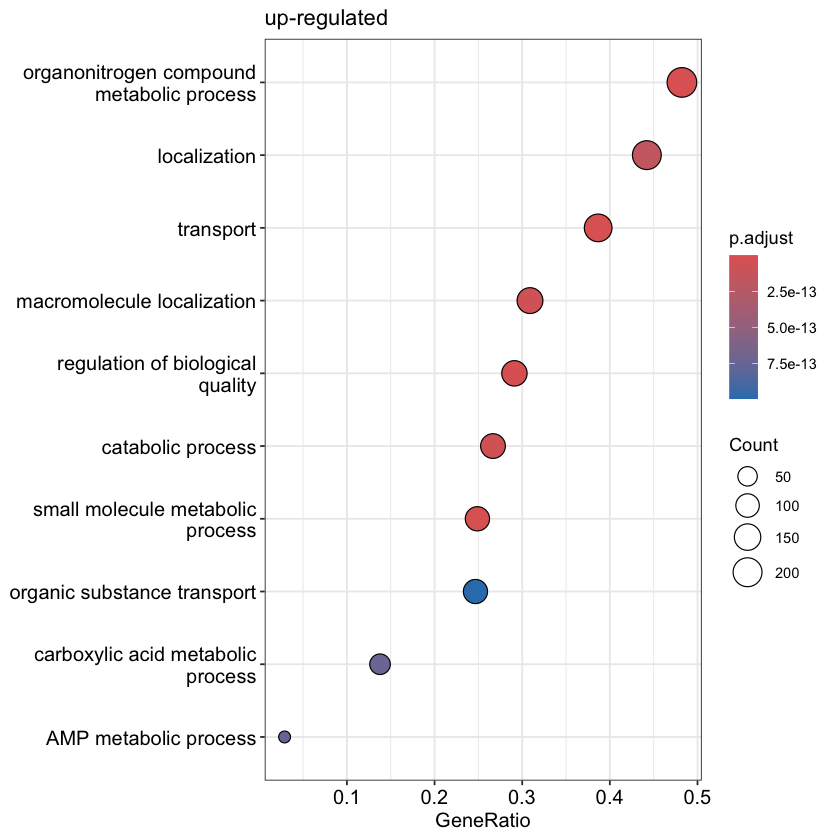

In [32]:
## Up-regulated proteins

# enrichment analysis using proteins names
multi_gp_up_reg <- gost(list("up-regulated" = up_names), multi_query = FALSE, evcodes = TRUE)
# modify the g:Profiler data frame
gp_mod_up <- multi_gp_up_reg$result[, c("query", "source", "term_id", "term_name", "p_value", "query_size", "intersection_size", "term_size", "effective_domain_size", "intersection")]
gp_mod_up <- gp_mod_up[order(gp_mod_up$p_value), ]
gp_mod_up_BP <- gp_mod_up[gp_mod_up$source == "GO:BP", ]
gp_mod_up_BP$GeneRatio <- paste0(gp_mod_up_BP$intersection_size, "/", gp_mod_up_BP$query_size)
gp_mod_up_BP$BgRatio <- paste0(gp_mod_up_BP$term_size, "/", gp_mod_up_BP$effective_domain_size)
names(gp_mod_up_BP) <- c("Cluster", "Category", "ID", "Description", "p.adjust", "query_size", "Count", "term_size", "effective_domain_size", "geneID", "GeneRatio", "BgRatio")
gp_mod_up_BP$geneID <- gsub(",", "/", gp_mod_up_BP$geneID)
row.names(gp_mod_up_BP) <- gp_mod_up_BP$ID
gp_mod_enrich_up_BP <- new("enrichResult", result = gp_mod_up_BP)

enrichplot::dotplot(gp_mod_enrich_up_BP, showCategory = 10) + ggplot2::labs(title = "up-regulated") + ggplot2::scale_color_gradient(low = "lightseagreen", high = "darkorange1")


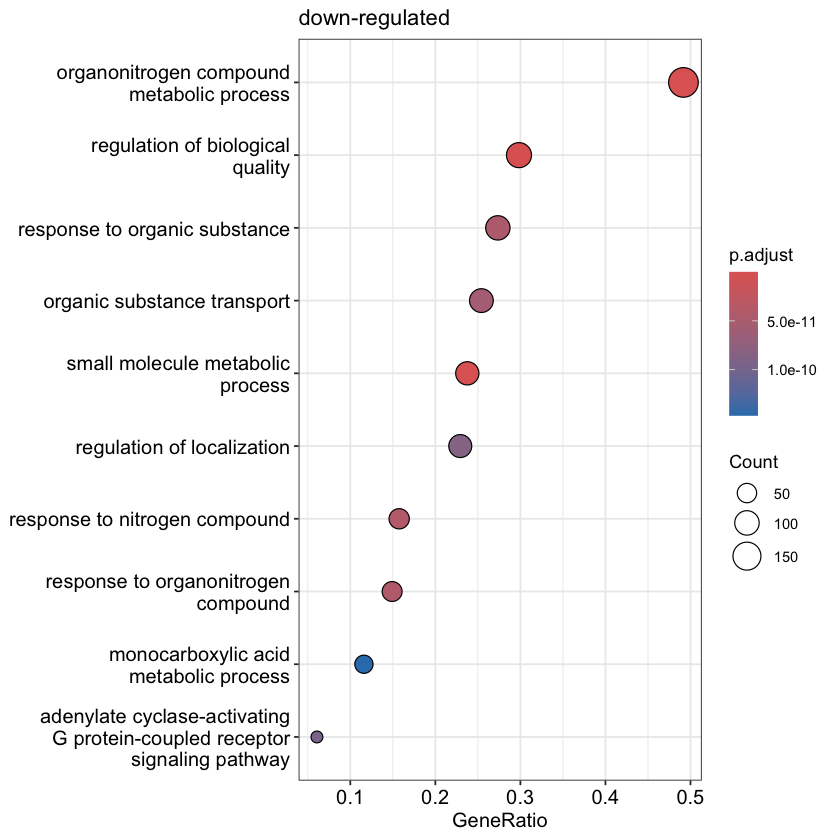

In [33]:
## Down-regulated proteins

# enrichment analysis using gene names
multi_gp_down_reg <- gost(list("down-regulated" = down_names), multi_query = FALSE, evcodes = TRUE)
# modify the g:Profiler data frame
gp_mod_down <- multi_gp_down_reg$result[, c("query", "source", "term_id", "term_name", "p_value", "query_size", "intersection_size", "term_size", "effective_domain_size", "intersection")]
gp_mod_down <- gp_mod_down[order(gp_mod_down$p_value), ]
# BP
gp_mod_down_BP <- gp_mod_down[gp_mod_down$source == "GO:BP", ]
gp_mod_down_BP$GeneRatio <- paste0(gp_mod_down_BP$intersection_size, "/", gp_mod_down_BP$query_size)
gp_mod_down_BP$BgRatio <- paste0(gp_mod_down_BP$term_size, "/", gp_mod_down_BP$effective_domain_size)
names(gp_mod_down_BP) <- c("Cluster", "Category", "ID", "Description", "p.adjust", "query_size", "Count", "term_size", "effective_domain_size", "geneID", "GeneRatio", "BgRatio")
gp_mod_down_BP$geneID <- gsub(",", "/", gp_mod_down_BP$geneID)
gp_mod_enrich_down_BP <- new("enrichResult", result = gp_mod_down_BP)

enrichplot::dotplot(gp_mod_enrich_down_BP, showCategory = 10) + ggplot2::labs(title = "down-regulated") + ggplot2::scale_color_gradient(low = "lightseagreen", high = "darkorange1")


LFC > 2 and LFC < -2 (four times greater differential expression)

In [34]:
# keep only the significant proteins results

sig <- subset(full_list, adj.P.Val < 0.05)
# get the significant up-regulated proteins
up <- subset(sig, logFC > 2)
# get the significant down-regulated proteins
down <- subset(sig, logFC < 2)

up_names <- gconvert(up$Prot)
down_names <- gconvert(down$Prot)


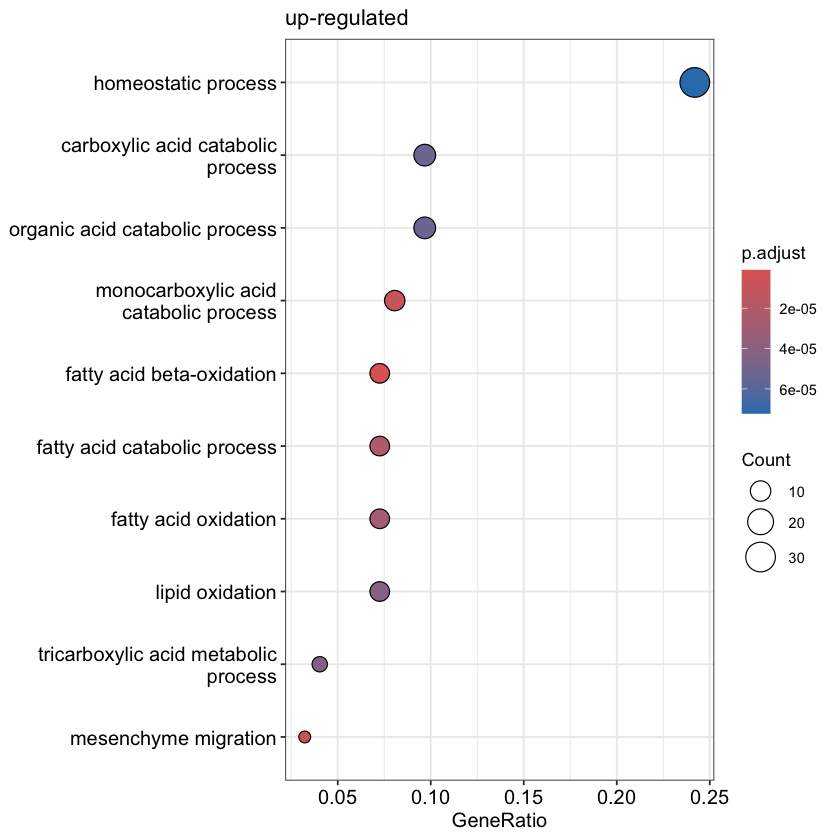

In [37]:
## Up-regulated proteins


multi_gp_up_reg <- gost(list("up-regulated" = up_names), multi_query = FALSE, evcodes = TRUE)
gp_mod_up <- multi_gp_up_reg$result[, c("query", "source", "term_id", "term_name", "p_value", "query_size", "intersection_size", "term_size", "effective_domain_size", "intersection")]
gp_mod_up <- gp_mod_up[order(gp_mod_up$p_value), ]
gp_mod_up_BP <- gp_mod_up[gp_mod_up$source == "GO:BP", ]
gp_mod_up_BP$GeneRatio <- paste0(gp_mod_up_BP$intersection_size, "/", gp_mod_up_BP$query_size)
gp_mod_up_BP$BgRatio <- paste0(gp_mod_up_BP$term_size, "/", gp_mod_up_BP$effective_domain_size)
names(gp_mod_up_BP) <- c("Cluster", "Category", "ID", "Description", "p.adjust", "query_size", "Count", "term_size", "effective_domain_size", "geneID", "GeneRatio", "BgRatio")
gp_mod_up_BP$geneID <- gsub(",", "/", gp_mod_up_BP$geneID)
row.names(gp_mod_up_BP) <- gp_mod_up_BP$ID
gp_mod_enrich_up_BP <- new("enrichResult", result = gp_mod_up_BP)

enrichplot::dotplot(gp_mod_enrich_up_BP, showCategory = 10) + ggplot2::labs(title = "up-regulated") + ggplot2::scale_color_gradient(low = "lightseagreen", high = "darkorange1")


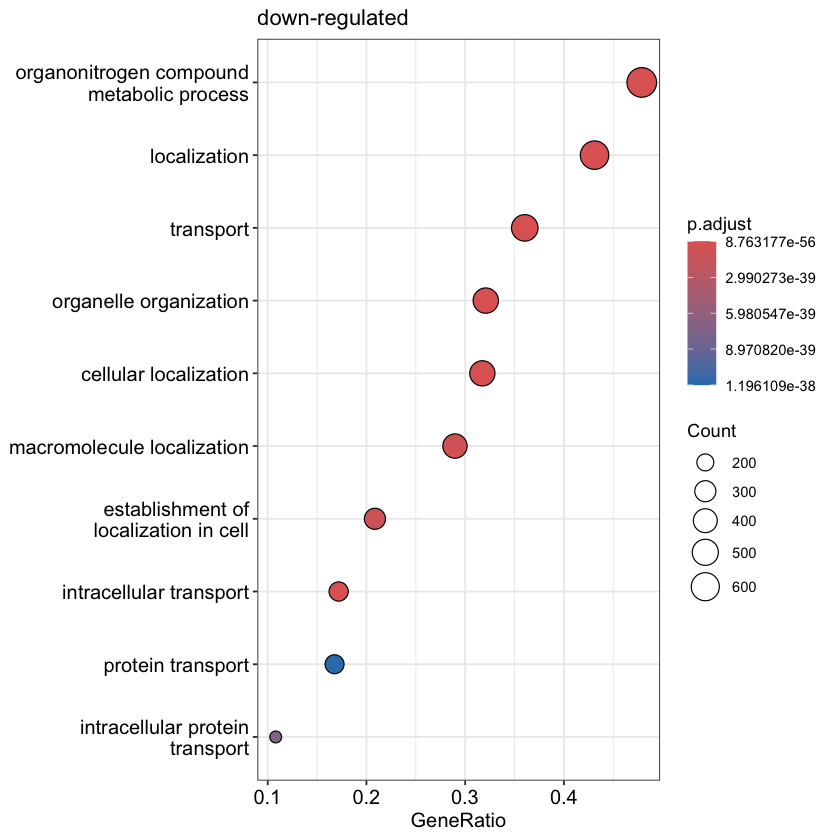

In [38]:
## Down-regulated proteins

multi_gp_down_reg <- gost(list("down-regulated" = down_names), multi_query = FALSE, evcodes = TRUE)
gp_mod_down <- multi_gp_down_reg$result[, c("query", "source", "term_id", "term_name", "p_value", "query_size", "intersection_size", "term_size", "effective_domain_size", "intersection")]
gp_mod_down <- gp_mod_down[order(gp_mod_down$p_value), ]
gp_mod_down_BP <- gp_mod_down[gp_mod_down$source == "GO:BP", ]
gp_mod_down_BP$GeneRatio <- paste0(gp_mod_down_BP$intersection_size, "/", gp_mod_down_BP$query_size)
gp_mod_down_BP$BgRatio <- paste0(gp_mod_down_BP$term_size, "/", gp_mod_down_BP$effective_domain_size)
names(gp_mod_down_BP) <- c("Cluster", "Category", "ID", "Description", "p.adjust", "query_size", "Count", "term_size", "effective_domain_size", "geneID", "GeneRatio", "BgRatio")
gp_mod_down_BP$geneID <- gsub(",", "/", gp_mod_down_BP$geneID)
gp_mod_enrich_down_BP <- new("enrichResult", result = gp_mod_down_BP)

enrichplot::dotplot(gp_mod_enrich_down_BP, showCategory = 10) + ggplot2::labs(title = "down-regulated") + ggplot2::scale_color_gradient(low = "lightseagreen", high = "darkorange1")


## Conclusion

"Organelle organisation," "intracellular transport of macromolecules," and "membrane localization of proteins" pathways can be linked to CJK formation due to the following mechanisms:

- Calcium transport: It's possible that these mechanisms are involved in the movement of calcium inside cells, which can build up in heart valve cells and cause calcification.
- Function of Membrane Proteins: The processes connected to the location of proteins in the membrane can affect how well membrane proteins work to control the passage of calcium across heart valve cell membranes. Variations in their position or function could influence calcium homeostasis and encourage the build-up of calcium in valve tissue.

- Metabolism and organelle function: Calcium metabolism may be influenced by cell organelles like mitochondria. Cellular calcium levels can be impacted by the malfunction of these enrichment process-related organelles, which can encourage calcification.

However, these are broad biological pathways that can be seen in both normal and malfunctioning samples.

But what is more notable, in with LFC threshold > 2 (4 times greater differentiation) there are more unique upregulated genes in CJK group compared to control group:
- "carboxilic and catabolic processes", "carboxic acid catabolic process": The chemical reactions and **pathways resulting in the breakdown of carboxylic acids can reduce glutathione synthesis** [1],  which acts as a reducing agent or binds toelectrophiles to neutralise reactive oxygen species (ROS); while oxidative stress, the imbalance between production and accumulation of ROS, is a known mediator of arterial calcification [1].

- "fatty acid beta-oxidation", "fatty acid catabolic processes", "fatty acid oxidation" and "lipid oxidation":  A series of inflammatory cell infiltrates, including macrophages and T lymphocytes, as well as the generation of pro-inflammatory cytokines, are brought on by **the existence of oxidated lipids and the ongoing lipid peroxidation process** within valve tissue. [2] The equilibrium between the extracellular matrix's synthesis and breakdown in the valve is disrupted by the pro-inflammatory cytokines and a decrease in nitric oxide availability. The underlying causes of dystrophic microcalcification are caused by such imbalance [2].

- "mesenchymal migration": Endothelial cells (EC) in CJK  can change into osteoblast-like cells and develop bone matrix; they can also convert from being endothelial to mesenchymal and generate matrix vesicles, which act as a nidus for microcalcifications [4]. Transformed ECs gain the mesenchymal phenotypic characteristics such as proliferation, **migration**, secretion, extracellular matrix


Overall, significantly enriched pathways upregulated in CJK group compared to contol group indicate the presence of oxidative stress, which is linked with CJK condition [3]. Another evidence is the fact that CJK is linked with smoking, which significantly increase oxidative stress.

[1] https://www.researchgate.net/publication/344241201_2-Oxothiazolidine-4-carboxylic_acid_inhibits_vascular_calcification_via_induction_of_glutathione_synthesis

[2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9274751/

[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9219756/

[4] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7220963/